In [12]:
import matplotlib
matplotlib.use('Agg')
import numpy as np
from numpy import exp, log, pi
import matplotlib.pyplot as plt
import scipy.stats
%matplotlib inline
matplotlib.rc('figure', dpi=120)


Creating significant correlations from nothing with degenerate models
============================================

Lets make a significant correlation! We set up a problem with a model degeneracy.

In this example, we fit a powerlaw with exponential cut-off.

Lets create and visualise the data:

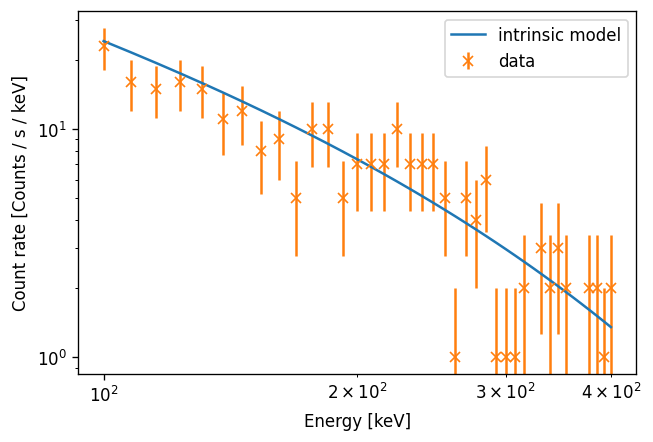

In [13]:
np.random.seed(1)

E = np.linspace(100, 400, 40)

def modelfunc(amplitude, slope, Ecut):
    return amplitude * (E / 100.)**-slope * exp(- E/Ecut)

paramnames = ['Amplitude', 'Photon index', 'Ecut']
ndim = len(paramnames)

slope_true = 1
amplitude_true = 40
Ecut_true = 200.0

model = modelfunc(amplitude_true, slope_true, Ecut_true)

plt.figure()
plt.plot(E, model, label='intrinsic model')
data = np.random.poisson(model)
# here we also use the shoddy technique of setting the error to the sqrt of the counts
plt.errorbar(x=E, y=data, yerr=data**0.5, marker='x', ls=' ', label='data')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Energy [keV]')
plt.ylabel('Count rate [Counts / s / keV]')
plt.legend(loc='best');


## Model fitting function

In [14]:

def logprob(params):
    amplitude, photonindex, Ecut = params
    if Ecut > 600 or Ecut < 10: return -np.inf
    logls = scipy.stats.poisson.logpmf(data, modelfunc(amplitude, photonindex, Ecut))
    logls[~np.isfinite(logls)] = -1e300
    return logls.sum()

values_true = [amplitude_true, slope_true, Ecut_true]


## Fit with a optimizer (Minuit)

We make it easy for the optimizer: We start it at the true values

In [15]:
from iminuit import Minuit

def find_best_fit(startparams):
    m = Minuit.from_array_func(
        lambda x: -logprob(x), 
        startparams,
        error=[1, 0.1, 10],
        name=paramnames,
        errordef=0.5,
    )
    m.migrad()

    # fmin = m.get_fmin()
    # like_best = -fmin.fval
    params_best = [m.values[i] for i in range(ndim)]
    errors = [m.errors[i] for i in range(ndim)]
    
    return params_best, errors


In [16]:
fit_values, fit_errors = find_best_fit(values_true)
fitsamples = np.random.normal(fit_values, fit_errors, size=(10000, ndim))

In [17]:
print('best fit:\n' +
    'amplitude = %.1f +- %.1f\n'  % (fit_values[0], fit_errors[0]) +
    'photonindex = %.1f +- %.1f\n'  % (fit_values[1], fit_errors[1]) +
    'Ecut = %.1f +- %.1f\n' % (fit_values[2], fit_errors[2]))

best fit:
amplitude = 44.5 +- 16.4
photonindex = 0.2 +- 0.9
Ecut = 117.6 +- 60.5



## Fit with MCMC

Again, we start at the true values.

In [18]:
from emcee import EnsembleSampler
num_walkers = 100
u = np.random.normal(values_true, [1, 0.1, 10], size=(num_walkers, ndim))
sampler = EnsembleSampler(num_walkers, ndim, logprob)
# burn-in:
sampler.run_mcmc(u, 100)  
last_samples = sampler.get_chain()[-1, :, :]
sampler.reset()
# sampling:
sampler.run_mcmc(last_samples, 100);
samples = sampler.get_chain(flat=True);

## Visualise fit results

Removed no burn in
Removed no burn in


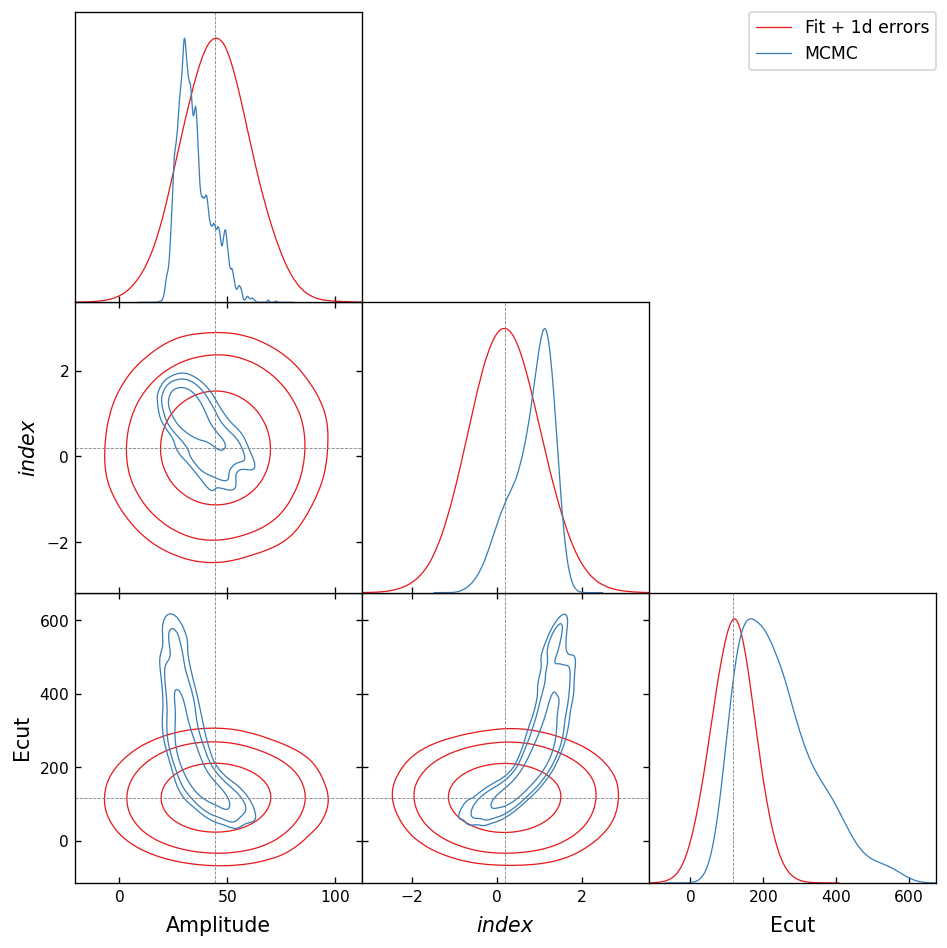

In [19]:
from getdist import MCSamples, plots
samples_g = MCSamples(samples=samples, names=paramnames, settings=dict(smooth_scale_2D=3.0), label='MCMC')

samples_f = MCSamples(samples=fitsamples, names=paramnames, settings=dict(smooth_scale_2D=3.0), label='Fit + 1d errors')

g = plots.get_subplot_plotter(width_inch=8)
g.settings.num_plot_contours = 3
g.triangle_plot([samples_f, samples_g], filled=False, contour_colors=plt.cm.Set1.colors, markers=fit_values);


## Differences to note

* Note how the minimizer (red) estimates uncertainties only per each dimension. 
* MCMC (blue) follows the degeneracy banana.



Lets generate a small sample
====================

In [20]:
np.random.seed(1)
N = 40
datasets = []
fits = []
chains = []
all_samples = []

for i in range(10):
    slope_true = 1
    amplitude_true = 1/np.random.uniform(1./40, 1/4000)
    Ecut_true = 200.0

    model = modelfunc(amplitude_true, slope_true, Ecut_true)
    data = np.random.poisson(model)
    datasets.append(data)
    
    fits.append(find_best_fit([amplitude_true, slope_true, Ecut_true]))
    
    u = np.random.normal([amplitude_true, slope_true, Ecut_true], size=(num_walkers, ndim))
    sampler = EnsembleSampler(num_walkers, ndim, logprob)
    # burn-in:
    sampler.run_mcmc(u, 100)
    last_samples = sampler.get_chain()[-1, :, :]
    sampler.reset()
    # sampling:
    sampler.run_mcmc(last_samples, 100);
    all_samples.append(sampler.get_chain(flat=True, thin=20))


/home/user/.local/lib/python3.6/site-packages/scipy/stats/_discrete_distns.py:598: RuntimeWarning: invalid value encountered in greater_equal
  return mu >= 0


Find best fit for each
-----------------------

linear regression: [100.05895963  95.90906541] errors: [ 5.06856775 12.36605614]


/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


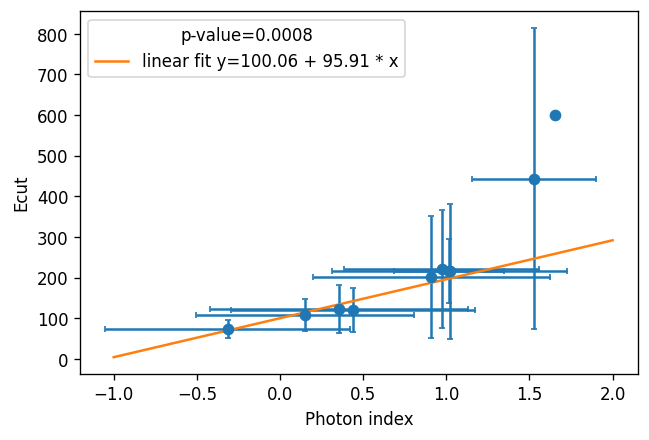

In [21]:
import scipy.optimize, scipy.stats

x = np.asarray([fit_values[1] for fit_values, fit_errors in fits])
y = np.asarray([fit_values[2] for fit_values, fit_errors in fits])
xerr = np.asarray([fit_errors[1] for fit_values, fit_errors in fits])
yerr = np.asarray([fit_errors[2] for fit_values, fit_errors in fits])

good = np.logical_and(xerr > 0, yerr > 0)

popt, pcov = scipy.optimize.curve_fit(lambda xv, a, b: (a + b*xv), x[good], y[good], p0=[200.0, 0.1], sigma=yerr[good])
print("linear regression:", popt, "errors:", np.diag(pcov)**0.5)
r, pvalue = scipy.stats.pearsonr(x, y)

plt.figure()
plt.errorbar(
    x=[fit_values[1] for fit_values, fit_errors in fits], 
    y=[fit_values[2] for fit_values, fit_errors in fits], 
    xerr=[fit_errors[1] for fit_values, fit_errors in fits], 
    yerr=[fit_errors[2] for fit_values, fit_errors in fits], 
    ls=' ', capsize=2, marker='o',
)
xp = np.linspace(-1, 2, 100)
yp = (popt[0] + popt[1] * xp)
plt.plot(xp, yp, label='linear fit y=%.2f + %.2f * x' % (popt[0], popt[1]))

plt.legend(title='p-value=%.4f' % pvalue)
plt.xlabel(paramnames[1])
plt.ylabel(paramnames[2]);

## Things to note

* This looks like a nice correlation!
* It is highly statistically significant
* Lets submit to Nature! (recall the true input for all is exactly Ecut=200 PhotonIndex=1)

How can we avoid being misled like this?

## Bayesian hierarchical model

Lets try with a population model. 

We assume:

- there is some intrinsic, but unknown distribution in the photon index
- there is some intrinsic, but unknown distribution in Ecut
- the Ecut distribution moves linearly with the photon index, but with an unknown slope
- We have posterior samples from each measurement, and want to use them.

In [22]:

def logprob_population(params):
    photonindex_mean, photonindex_std, Ecut_mean0, Ecut_std, relation_slope = params
    if photonindex_std <= 0.1: return -np.inf
    if Ecut_std <= 1: return -np.inf
    
    # compute for each posterior point the probability of this model
    logprob = 0
    
    for samples in all_samples:
        amplitude, photonindex, Ecut = samples.transpose()
        
        # photon index distribution
        prob_photonindex = (np.exp(-0.5 * (((photonindex - photonindex_mean) / photonindex_std)**2))/(2 * pi * photonindex_std**2)**0.5).mean()
        
        # energy cutoff distribution:
        Ecut_mean = Ecut_mean0 + relation_slope * photonindex
        prob_Ecut = (np.exp(-0.5 * (((Ecut - Ecut_mean) / Ecut_std)**2))/(2 * pi * Ecut_std**2)**0.5).mean()
        logprob += np.log(prob_photonindex * prob_Ecut + 1e-300)
    
    return logprob


from emcee import EnsembleSampler
np.random.seed(1)
num_walkers = 100
paramnames_population = ['photonindex_mean', 'photonindex_std', 'Ecut_mean0', 'Ecut_std', 'relation_slope']
ndim_population = 5
u = np.random.normal([0., 1.0, 200, 100, 100.], [1, 0.1, 1, 0.1, 1.0], size=(num_walkers, ndim_population))
sampler = EnsembleSampler(num_walkers, ndim_population, logprob_population)
# burn-in:
sampler.run_mcmc(u, 100, progress=True)
last_samples = sampler.get_chain()[-1, :, :]
sampler.reset()
# sampling:
sampler.run_mcmc(last_samples, 1000, progress=True);
samples_population = sampler.get_chain(flat=True);

100%|██████████| 1000/1000 [00:38<00:00, 26.20it/s]


Removed no burn in


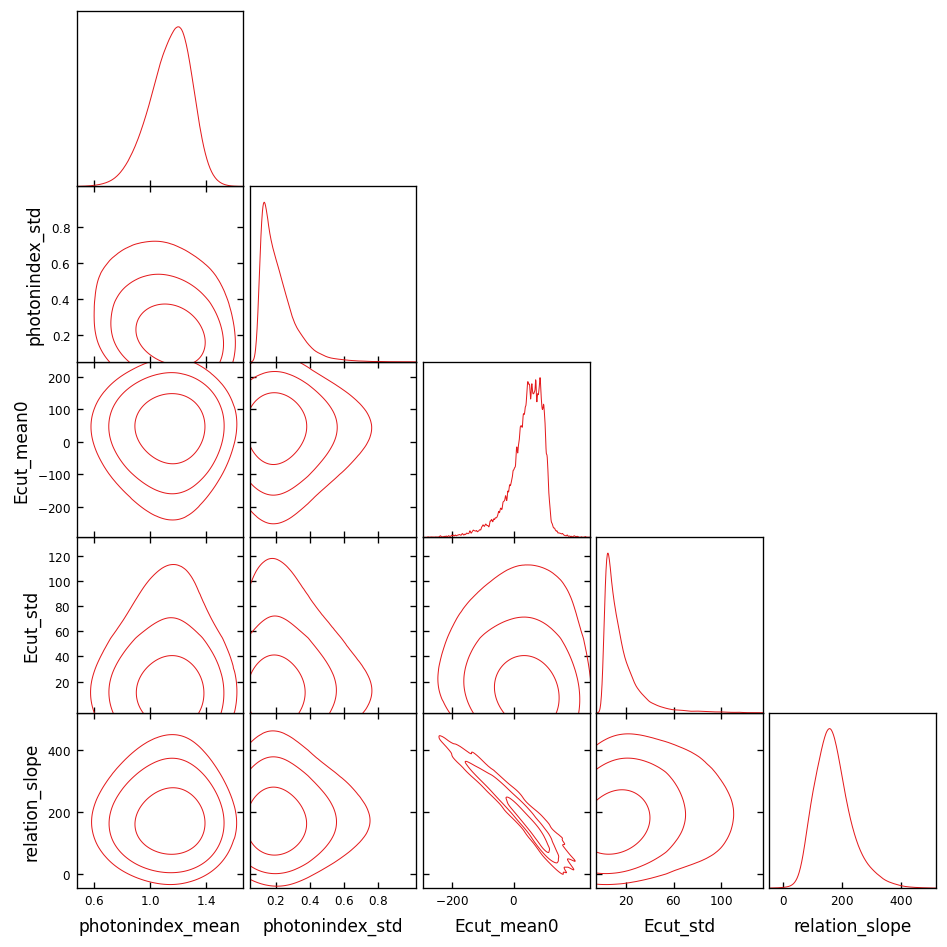

In [23]:
from getdist import MCSamples, plots
samples_g = MCSamples(samples=samples_population, names=paramnames_population, 
                      settings=dict(smooth_scale_2D=3.0), label='HBM population parameters')

g = plots.get_subplot_plotter(width_inch=8)
g.settings.num_plot_contours = 3
g.triangle_plot([samples_g], filled=False, contour_colors=plt.cm.Set1.colors,
               marker=[slope_true, 0, Ecut_true, 0, 0]);


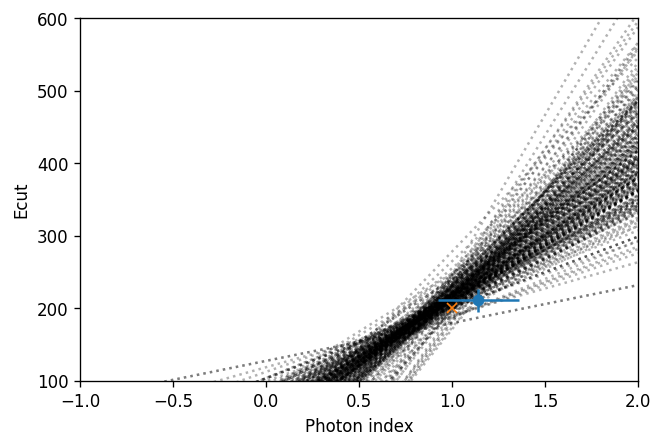

In [24]:
xp = np.linspace(-1, 2, 100)

plt.figure()
for photonindex_mean, photonindex_std, Ecut_mean0, Ecut_std, relation_slope in samples_population[::400,:]:
    yp = Ecut_mean0 + relation_slope * xp
    plt.plot(xp, yp, ':k', alpha=0.3)

plt.errorbar(
    x=samples_population[:,0].mean(), xerr=samples_population[:,1].mean(), 
    y=(samples_population[:,2] + 1*samples_population[:,4]).mean(), yerr=samples_population[:,3].mean(),
    marker='o', zorder=3,
    label='Inferred distribution',
)
plt.plot(slope_true, Ecut_true, marker='x', zorder=4, label='Truth (input)')

#plt.legend(title='p-value=%.4f' % pvalue)
plt.xlim(-1, 2)
plt.ylim(100, 600)
plt.xlabel(paramnames[1])
plt.ylabel(paramnames[2]);


## What the Hierarchical Bayesian model tells us

* The intrinsic dispersion in Ecut and Photon index (blue error bar above) is very, very small! We assumed it is >0, note how the std parameters go towards zero.

* If there is a linear relation, it is positive, but quite uncertain.

* The HBM tells us that the population is likely compatible with a single photon index & Ecut value. We could test this with model comparison.

Keep in mind: Using emcee to fit HBMs is not wise. Use UltraNest for low-dimensional problems, or Stan which is more flexible.

I used this method in [Buchner+17](https://ui.adsabs.harvard.edu/abs/2017MNRAS.464.4545B/abstract)